In [1]:
!nvidia-smi

Wed Apr  2 11:48:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P3              8W /   75W |     469MiB /   6144MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [26]:
import SimpleITK as sitk
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
# import torch
# from torch.utils.data import Dataset
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Name:", tf.config.list_physical_devices('GPU'))
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import plot_model, to_categorical
tf.debugging.set_log_device_placement(False)
tf.config.experimental_run_functions_eagerly(False)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
tf.debugging.set_log_device_placement(False)
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from keras.layers import TFSMLayer
from keras import Input, Model
# from torch.utils.data import DataLoader
from scipy.ndimage import zoom
from glob import glob
import re
from skimage import measure
import torchio as tio
import shutil
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

TensorFlow Version: 2.19.0
Num GPUs Available: 0
GPU Name: []


In [21]:
PROCESSED_DIR = "D:\Advanced_Python\projects\MLMED\cropped_slices_processed_320"
i = 0
for dataset in ['testing']:
    dataset_path = os.path.join(PROCESSED_DIR, dataset)
    print(f"\n📁 Dataset: {dataset}\n{'-' * 40}")
    
    for patient_folder in os.listdir(dataset_path):
        patient_path = os.path.join(dataset_path, patient_folder)
        
        if not os.path.isdir(patient_path):
            continue
        
        for file in os.listdir(patient_path):
            if file.endswith(".nii.gz"):
                file_path = os.path.join(patient_path, file)
                
                try:
                    img = nib.load(file_path)
                    voxel_spacing = img.header.get_zooms()
                    shape = img.shape
                    i += 0.5
                    print(f"- {file_path}")
                    print(f"  🧊 Spacing: {voxel_spacing}")
                    print(f"  📐 Shape: {shape}")
                    print(f"  ℹ️ Index: {i}\n")
                except Exception as e:
                    print(f"❌ Error loading {file_path}: {e}")


📁 Dataset: testing
----------------------------------------
- D:\Advanced_Python\projects\MLMED\cropped_slices_processed_320\testing\patient101\patient101_ED_gt_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (224, 224, 9)
  ℹ️ Index: 0.5

- D:\Advanced_Python\projects\MLMED\cropped_slices_processed_320\testing\patient101\patient101_ED_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (224, 224, 9)
  ℹ️ Index: 1.0

- D:\Advanced_Python\projects\MLMED\cropped_slices_processed_320\testing\patient101\patient101_ES_gt_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (224, 224, 8)
  ℹ️ Index: 1.5

- D:\Advanced_Python\projects\MLMED\cropped_slices_processed_320\testing\patient101\patient101_ES_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (224, 224, 8)
  ℹ️ Index: 2.0

- D:\Advanced_Python\projects\MLMED\cropped_slices_processed_320\testing\patient102\patient102_ED_gt_processed.nii.gz
  🧊 Spacing: (1.0, 1.0, 1.0)
  📐 Shape: (224, 224, 7)
  ℹ️ Index: 2.5



In [27]:
def crop_or_pad_volume(volume, target_shape=(224, 224, 10)):
    z, x, y = volume.shape
    z_target, x_target, y_target = target_shape

    if z < z_target:
        pad_z = z_target - z
        pad_before = pad_z // 2
        pad_after = pad_z - pad_before
        volume = np.pad(volume, ((pad_before, pad_after), (0, 0), (0, 0)), mode='constant')
    elif z > z_target:
        start_z = (z - z_target) // 2
        volume = volume[start_z:start_z + z_target, :, :]

    if x < x_target or y < y_target:
        volume = np.pad(volume, ((0, 0), (0, x_target - x), (0, y_target - y)), mode='constant')
    elif x > x_target or y > y_target:
        start_x = (x - x_target) // 2
        start_y = (y - y_target) // 2
        volume = volume[:, start_x:start_x + x_target, start_y:start_y + y_target]

    return volume

def load_patient_volume(patient_folder, num_classes=4):
    images, masks = [], []

    for phase in ["ED", "ES"]:
        image_path = os.path.join(patient_folder, f"patient{patient_folder[-3:]}_{phase}_processed.nii.gz")
        mask_path = os.path.join(patient_folder, f"patient{patient_folder[-3:]}_{phase}_gt_processed.nii.gz")

        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"⚠️ Missing file: {image_path} or {mask_path}")
            continue  

        image_nii = nib.load(image_path)
        mask_nii = nib.load(mask_path)

        image_array = image_nii.get_fdata()
        mask_array = mask_nii.get_fdata()

        image_array = (image_array - np.mean(image_array)) / (np.std(image_array) + 1e-10)

        image_array = crop_or_pad_volume(image_array, target_shape=(224, 224, 10))
        mask_array = crop_or_pad_volume(mask_array, target_shape=(224, 224, 10))

        image_array = np.expand_dims(image_array, axis=-1)
        mask_array = to_categorical(mask_array, num_classes=num_classes).astype("float32")

        images.append(image_array)
        masks.append(mask_array)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

def load_dataset(root_dir, dataset_type):
    images, masks = [], []
    dataset_path = os.path.join(root_dir, dataset_type)

    for patient_folder in sorted(os.listdir(dataset_path)):
        patient_path = os.path.join(dataset_path, patient_folder)

        if os.path.isdir(patient_path):
            patient_id = patient_folder[-3:]
            patient_images, patient_masks = load_patient_volume(patient_path, num_classes=4)
            print(f"✅ Loaded {len(patient_images)} volumes and {len(patient_masks)} masks from {patient_folder}")
            images.extend(patient_images)
            masks.extend(patient_masks)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

X_test, Y_test = load_dataset(r'D:\Advanced_Python\projects\MLMED\cropped_slices_processed_320', 'testing')
print(f"✅ Testing Data: {X_test.shape}, {Y_test.shape}")

✅ Loaded 2 volumes and 2 masks from patient101
✅ Loaded 2 volumes and 2 masks from patient102
✅ Loaded 2 volumes and 2 masks from patient103
✅ Loaded 2 volumes and 2 masks from patient104
✅ Loaded 2 volumes and 2 masks from patient105
✅ Loaded 2 volumes and 2 masks from patient106
✅ Loaded 2 volumes and 2 masks from patient107
✅ Loaded 2 volumes and 2 masks from patient108
✅ Loaded 2 volumes and 2 masks from patient109
✅ Loaded 2 volumes and 2 masks from patient110
✅ Loaded 2 volumes and 2 masks from patient111
✅ Loaded 2 volumes and 2 masks from patient112
✅ Loaded 2 volumes and 2 masks from patient113
✅ Loaded 2 volumes and 2 masks from patient114
✅ Loaded 2 volumes and 2 masks from patient115
✅ Loaded 2 volumes and 2 masks from patient116
✅ Loaded 2 volumes and 2 masks from patient117
✅ Loaded 2 volumes and 2 masks from patient118
✅ Loaded 2 volumes and 2 masks from patient119
✅ Loaded 2 volumes and 2 masks from patient120
✅ Loaded 2 volumes and 2 masks from patient121
✅ Loaded 2 vo

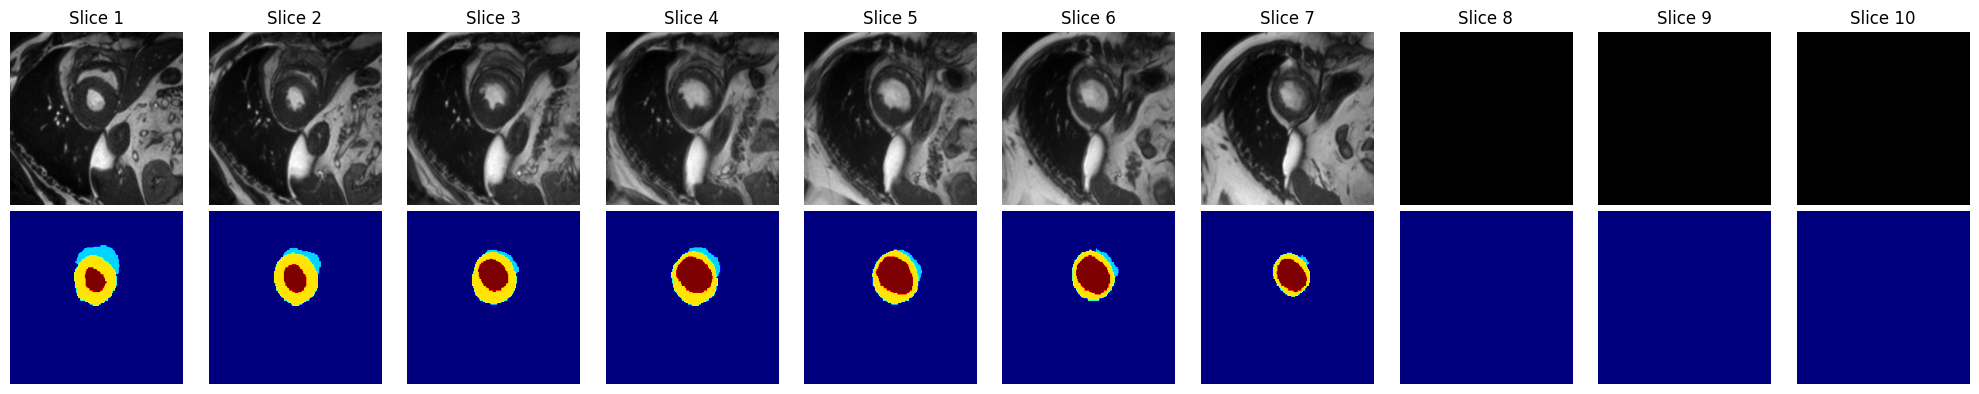

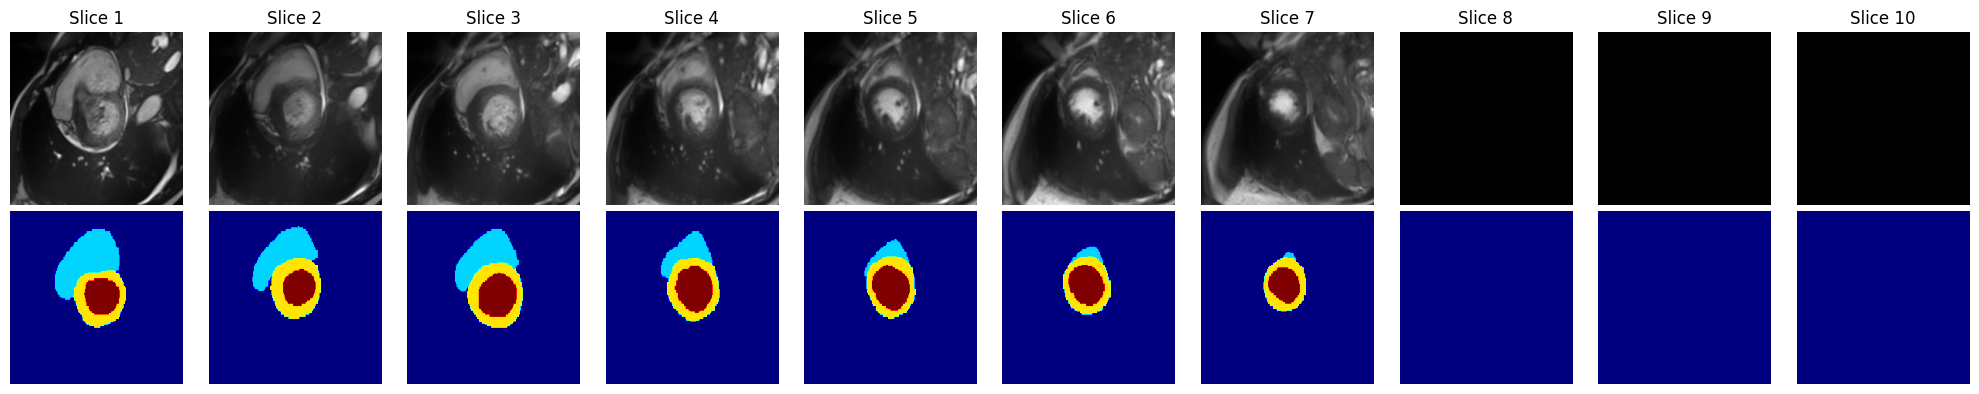

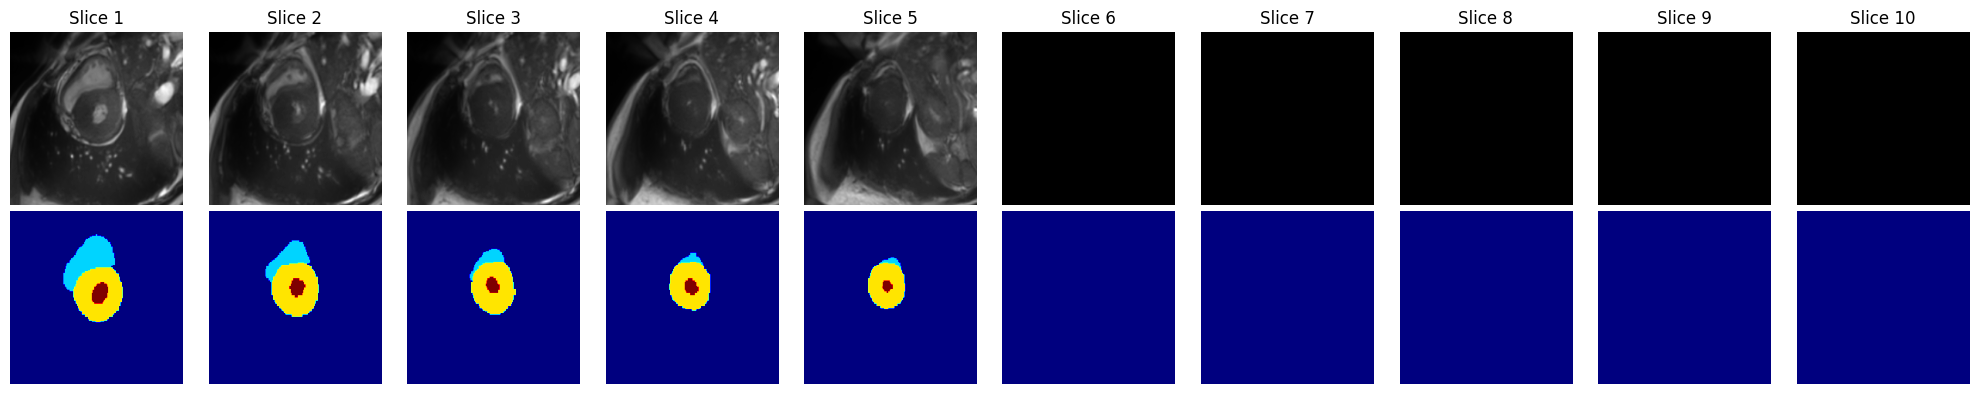

In [29]:
def visualize_3d(x, y, index):
    volume = x[index, ..., 0]  
    mask = y[index, ..., :]  

    depth = volume.shape[-1]

    fig, axs = plt.subplots(2, depth, figsize=(2 * depth, 4))

    for i in range(depth):
        axs[0, i].imshow(volume[..., i], cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title(f'Slice {i+1}')

        seg_slice = np.argmax(mask[..., i, :], axis=-1)
        axs[1, i].imshow(seg_slice, cmap='jet', vmin=0, vmax=3)  
        axs[1, i].axis('off')

    axs[0, 0].set_ylabel("MRI", rotation=0, labelpad=30)
    axs[1, 0].set_ylabel("Mask", rotation=0, labelpad=30)

    plt.tight_layout()
    plt.show()
for i in range(5, 8):
    visualize_3d(X_test, Y_test, i)

In [3]:
def downsample_mask_tf(mask, target_size):
    target_x, target_y = target_size
    mask = tf.transpose(mask, [2, 0, 1, 3])  
    downsampled = tf.image.resize(mask, (target_x, target_y), method='nearest')
    downsampled = tf.transpose(downsampled, [1, 2, 0, 3])  
    return downsampled

def prepare_targets(image, main_mask):
    ds2_mask = downsample_mask_tf(main_mask, (112, 112))  
    ds1_mask = downsample_mask_tf(main_mask, (56, 56))   
    return image, {'main': main_mask, 'ds1': ds1_mask, 'ds2': ds2_mask}

def random_gamma_3d(image):
    image = tf.clip_by_value(image, 1e-3, 1.0)
    gamma = tf.random.uniform([], 0.9, 1.1)
    return tf.pow(image, gamma)

def augment_3d(image, main_mask):
    if tf.random.uniform(()) > 0.9:
        image = tf.reverse(image, axis=[1])
        main_mask = tf.reverse(main_mask, axis=[1])
    if tf.random.uniform(()) > 0.9:
        image = tf.reverse(image, axis=[0])
        main_mask = tf.reverse(main_mask, axis=[0])
    if tf.random.uniform(()) > 0.6:
        image = random_gamma_3d(image)
    if tf.random.uniform(()) > 0.9:
        offset = tf.random.normal([1], mean=0.0, stddev=20.0, dtype=tf.float32)
        shift = tf.cast(offset, tf.int32)[0]
        image = tf.roll(image, shift=shift, axis=2)
        main_mask = tf.roll(main_mask, shift=shift, axis=2)
    return image, main_mask

def create_tf_dataset(images, masks, batch_size, augment_data=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    if augment_data:
        dataset = dataset.map(augment_3d, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(prepare_targets, num_parallel_calls=tf.data.AUTOTUNE)
    # dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE) # If and only if you want to shuffle
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    test_dataset = create_tf_dataset(X_test, Y_test, batch_size=1, augment_data=False)

for batch in test_dataset.take(1):
    images, targets = batch
    print("Batch image shape:", images.shape)
    print("Batch targets shapes:", {k: v.shape for k, v in targets.items()})

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Batch image shape: (1, 224, 224, 10, 1)
Batch targets shapes: {'main': TensorShape([1, 224, 224, 10, 4]), 'ds1': TensorShape([1, 56, 56, 10, 4]), 'ds2': TensorShape([1, 112, 112, 10, 4])}


In [4]:
def dice_loss_per_class_3d(y_true, y_pred, num_classes=4, smooth=1e-6):
    dice_scores = []
    for i in range(1, num_classes):
        y_true_class = K.flatten(y_true[..., i])  
        y_pred_class = K.flatten(y_pred[..., i])
        intersection = K.sum(y_true_class * y_pred_class)
        dice = (2. * intersection + smooth) / (K.sum(y_true_class) + K.sum(y_pred_class) + smooth)
        dice_scores.append(dice)
    mean_dice = K.mean(K.stack(dice_scores), axis=0)
    return 1 - mean_dice
def dice_score_per_class_3d(y_true, y_pred, num_classes=4, smooth=1e-6):
    dice_scores = []
    for i in range(1, num_classes):  
        y_true_class = K.flatten(y_true[..., i])
        y_pred_class = K.flatten(y_pred[..., i])
        intersection = K.sum(y_true_class * y_pred_class)
        dice = (2. * intersection + smooth) / (K.sum(y_true_class) + K.sum(y_pred_class) + smooth)
        dice_scores.append(dice)
    return K.mean(K.stack(dice_scores), axis=0)  

def dice_per_class_individual(y_true, y_pred, num_classes=4, smooth=1e-6):
    scores = []
    for i in range(num_classes):
        y_true_class = K.flatten(y_true[..., i])
        y_pred_class = K.flatten(y_pred[..., i])
        intersection = K.sum(y_true_class * y_pred_class)
        dice = (2. * intersection + smooth) / (K.sum(y_true_class) + K.sum(y_pred_class) + smooth)
        scores.append(dice)
    return scores

In [5]:
layer = TFSMLayer(
    r"D:\Advanced_Python\projects\MLMED\models\best_unet3D_224x224x10",
    call_endpoint="serving_default"
)

inputs = Input(shape=(224, 224, 10, 1))  
outputs = layer(inputs)
model = Model(inputs, outputs)

In [6]:
all_y_true = []
all_y_pred = []

for batch in test_dataset:
    images, targets = batch
    y_true = targets['main'] 
    
    y_pred_dict = model(images, training=False)
    y_pred = y_pred_dict['main'] if isinstance(y_pred_dict, dict) else y_pred_dict[0]

    all_y_true.append(y_true)
    all_y_pred.append(y_pred)

y_true_full = tf.concat(all_y_true, axis=0)
y_pred_full = tf.concat(all_y_pred, axis=0)

In [7]:
dice_score = dice_score_per_class_3d(y_true_full, y_pred_full)

print(f"✅ Mean Dice Score (RVC, LVM, LVC): {dice_score*100:.4f}")

dice_individual = dice_per_class_individual(y_true_full, y_pred_full)

classes = ["Fuck This", "RVC", "LVM", "LVC"]
for i in range(1, 4):
    print(f"✅ Dice Coefficient for class {classes[i]}: {dice_individual[i]*100:.4f}")

✅ Mean Dice Score (RVC, LVM, LVC): 88.6692
✅ Dice Coefficient for class RVC: 88.3926
✅ Dice Coefficient for class LVM: 83.6632
✅ Dice Coefficient for class LVC: 93.9518


Đưa về series of 2D slices để check.

In [22]:
def dice_score_each_individual_class(y_true, y_pred, num_classes=4, smooth=1e-6):
    dice_scores = []

    for i in range(1, num_classes):
        y_true_class = tf.keras.backend.flatten(y_true[..., i])
        y_pred_class = tf.keras.backend.flatten(y_pred[..., i])

        intersection = tf.keras.backend.sum(y_true_class * y_pred_class)
        dice = (2. * intersection + smooth) / (
            tf.keras.backend.sum(y_true_class) + tf.keras.backend.sum(y_pred_class) + smooth
        )
        dice_scores.append(dice)

    return dice_scores  

In [23]:
y_true_flat = tf.reshape(y_true_full, [-1, 224, 224, 4])
y_pred_flat = tf.reshape(y_pred_full, [-1, 224, 224, 4])
dice_scores = dice_score_each_individual_class(y_true_flat, y_pred_flat)

In [25]:
score_arr = []
for i, score in enumerate(dice_scores):
    print(f"Dice score for class {i}: {(score.numpy()*100):.4f}")
    score_arr.append(score)
    
total_score = 0
for score in score_arr:
    total_score+=score
print(f"Average of 3 main classes: {total_score/3*100:.4f}")

Dice score for class 0: 88.3926
Dice score for class 1: 83.6632
Dice score for class 2: 93.9518
Average of 3 main classes: 88.6692


224x224x10:
- 26 channels: 88.6692 - 88.3926 - 83.6632 - 93.9518
- 32 channels: 88.4289 - 89.3833 - 82.2545 - 93.6490
- 48 channels: god knows máy đ đủ mem